In [4]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from enum import Enum
from numpy import random
%matplotlib inline

np.set_printoptions(formatter={'float': lambda x: '{:.3}'.format(x)})

In [5]:
class ProgressBar(object):
    
    def __init__(self, total, prefix='', suffix='', decimals=1, length=100, fill='█'):
        """
        Creates terminal progress bar instance.
        @params:
            total      - Required  : total iterations (Int)
            prefix     - Optional  : prefix string (Str)
            suffix     - Optional  : suffix string (Str)
            decimal    - Optional  : positive number of decimals in percent complete (Int)
            length     - Optional  : character length of bar (Int):
            fill       - Optional  : bar fill character (Str)
        """
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill


    def print_bar(self, iteration):
        """
        Updates progress bar status.
        @params:
            iteration  - Required  : current iteration (Int)
        """
        percent = ("{0:." + str(self.decimals) + "f}").format(
                        100 * (iteration / float(self.total)))
        filled_length = int(self.length * iteration // self.total)
        bar = self.fill * filled_length + '-' * (self.length - filled_length)

        print('\r{} |{}| {}% {}'.format(self.prefix, bar, percent, self.suffix), end='\r')

        # print a new line on complete
        if iteration == self.total:
            print()


class Id(object):
    """
    ID generator - a singleton class.

    Example:
        ID = Id()
        Id.get()
    """

    class __Id:

        def __init__(self):
            self.generator = self.id_gen()

        def id_gen(self):
            id_ = 0
            while True:
                yield id_
                id_ += 1

        def get(self):
            return next(self.generator)
        
        def reset(self):
            self.generator = self.id_gen()

    instance = None

    def __new__(cls):
        if not Id.instance:
            Id.instance = Id.__Id()
        return Id.instance

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def __setattr__(self, name):
        return setattr(self.instance, name)


TOLERANCE = 1e-15


def vec3D(x, y, z):
    return np.array([x, y, z])

def normalize(x):
    norm = la.norm(x)
    return x / norm if norm > TOLERANCE else vec3D(0.,0.,0.)

def to_log_scale(lin_scaled):
    return 10 * np.log10(lin_scaled) if lin_scaled > TOLERANCE else -np.inf

def to_lin_scale(log_scaled):
    return np.exp(log_scaled / 10)

def power(amplitude):
    return np.abs(amplitude) ** 2


## Geometry

**Plane**  
Projection point of RX:
$$ \mathcal{Pr}[\vec{r}] = \vec{r}_P = \vec{r}_{RX} - 2 (\vec{r}_{RX} - \vec{r}_0, \vec{n}) \vec{n} $$

Intersection or reflection point:
$$ \mathcal{In}[\vec{r}] = \vec{r}_I = \vec{r}_{TX} - 
\frac{(\vec{r}_{TX} - \vec{r}_0, \vec{n})}{(\vec{D_1}, \vec{n})} \vec{D_1} $$

where direction of grazing ray $\vec{d_1} = \vec{D_1} / D_1$:
$$ \vec{D_1} = \vec{r}_P - \vec{r}_{TX} = \vec{r}_{RX} - \vec{r}_{TX} - 2 (\vec{r}_{RX} - \vec{r}_0, \vec{n})$$

Direction of reflected ray $\vec{d_2} = \vec{D_2} / D_2$:
$$ \vec{D_2} = \vec{r}_{RX} - \vec{r}_I = \vec{r}_{RX} - \vec{r}_{TX} + 
\frac{(\vec{r}_{TX} - \vec{r}_0, \vec{n})}{(\vec{D_1}, \vec{n})} \vec{D_1}$$


In [6]:
class Shape(object):

    def get_normal(self, surface_point):
        pass
    
    def intersect(self, start, direction):
        return np.inf


class Plane(Shape):
    
    TOLERANCE = 1e-6
    
    def __init__(self, init_point, normal, reflection=1.+0.j):
        self.init_point = init_point
        self.normal = normal
        self.reflection = reflection


    def get_normal(self, surface_point):
        return self.normal


    def intersect(self, start, direction):

        denom = np.dot(direction, self.normal)
        if np.abs(denom) < Plane.TOLERANCE:
            return np.inf

        tau = np.dot(self.init_point - start, self.normal) / denom
        if tau < 0:
            return np.inf

        return tau


    def project(self, point):
        
        return point - 2 * np.dot(point - self.init_point, self.normal) * self.normal


    def reflect(self, start, end):

        dir_grazing = self.project(end) - start
        dir_grazing = normalize(dir_grazing)

        tau = self.intersect(start, dir_grazing)
        if tau == np.inf:
            return None

        intersection = start + tau * dir_grazing
        dir_reflected = end - intersection
        dir_reflected = normalize(dir_reflected)

        return intersection, dir_grazing, dir_reflected

## Ray and RayTree definition

In [88]:
class Ray(object):

    c = 299792458. # speed of light, in mps

    class Type(Enum):
        PRIMARY = 0
        REFLECTED = 1
        REFRACTED = 2
    
    def __init__(self, k, start, end=None, direction=None, compute_att=False, 
                 r_atts=1., path_len=0., type_=Type.PRIMARY):

        self.id = Id().get()
        self.type = type_

        # Geometrical properties
        assert end is not None or direction is not None, \
            'Ray: end and direction cannot be None simulteneously'

        self.start = start
        self.end = end
        self.direction = direction if direction is not None else normalize(end - start)            
        self.length = la.norm(end - start) if end is not None else -1.

        # Propagation parameters
        self.r_atts = r_atts
        self.k = k
        self.path_len = path_len
        
        self.delay = 0.
        self.att = 0.j
        
        if compute_att:
            self.attenuation()


    def __str__(self):
        string = '<{}({}) start={} end={} dir={} len={:>4.3}; k={:>4.3}, A={:>4.3f}, delay={:>4.3}>'
        return string.format(self.type.name, self.id, self.start, self.end, self.direction, 
                             self.length, self.k, to_log_scale(np.abs(self.att) ** 2), self.delay)

    def set_end(self, end):
        self.end = end
        self.length = la.norm(self.end - self.start)


    def attenuation(self, time=0., rspeed=None):
        full_len = self.length + self.path_len
        self.att = .5 / (self.k * full_len) * np.exp(-1j * self.k * full_len) * self.r_atts
        return self.att

    def delay(self):
        self.delay = (self.length + self.path_len) / c
        return self.delay

    def doppler_shift(self, rspeed):
        return .5 / np.pi * self.k * np.dot(self.direction, rspeed)




class RayNode(object):
    
    def __init__(self, ray, parent=None):

        self.ray = ray
        self.parent = parent
        self.reflected = None
        self.refracted = None

        self.id = ray.id
        self.depth = parent.depth + 1 if parent else 0


    def __str__(self):
        reflected_id = str(self.reflected.ray.id) if self.reflected else '.'
        refracted_id = str(self.refracted.ray.id) if self.refracted else '.'
        self_id = str(self.ray.id)
        return '({})<({})>({})'.format(refracted_id, self_id, reflected_id)

            
    def view(self):
        refracted_view = self.refracted.view() if self.refracted else '.'
        reflected_view = self.reflected.view() if self.reflected else '.'
        return '[{}]<({})>[{}]'.format(refracted_view, str(self.ray.id), reflected_view)


# TODO: raise exception if adding to a leave
class RayTree(object):
    
    def __init__(self, ray, leave=False):

        self.root_ = RayNode(ray)
        self.current_ = self.root_

        self.rays_ = {ray.id: ray}
        self.levels_ = {0: ray.id}
        self.leaves_ = list()
        if leave:
            self.leaves_.append(ray.id)


    def __str__(self):
        return self.root_.view()


    def add_ray(self, ray, leave=False):
    
        if ray.type is Ray.Type.REFLECTED:
            self.current_.reflected = RayNode(ray, self.current_)

        elif ray.type is Ray.Type.REFLECTED:
            self.current_.refracted = RayNode(ray, self.current_)

        self.rays_[ray.id] = ray
        self.levels_[self.current_.depth] = ray.id
        if leave:
            self.leaves_.append(ray.id)


    def get_reflected(self):
        self.current_ = self.current_.reflected
        return self

    def get_refrected(self):
        self.current_ = self.current_.refracted
        return self

    def get_leaves(self):
        return [self.rays_[ray_id] for ray_id in self.leaves_]

    def get_rays(self):
        return self.rays_.values()

## Radio Ray Tracer

In [89]:
class RadioRayTracer(object):
    
    def __init__(self, scene, wavelen, k):
        self.scene = scene
        self.wavelen = wavelen
        self.k = k


    # TODO: handle checking intersections
    def run(self, tx_pos, rx_pos):

        forest = []

        # Compute a line-of-sight component
        ray = Ray(self.k, tx_pos, rx_pos, compute_att=True)
        forest.append(RayTree(ray, leave=True))

#         Compute 1-reflected components
        for shape in self.scene:

            output = shape.reflect(tx_pos, rx_pos)
            if not output:
                continue
            
            intersection, dir_grazing, dir_reflected = output
            
            ray_primary = Ray(self.k, tx_pos, intersection, dir_grazing)
            path_length = ray_primary.length

            ray_reflected = Ray(self.k, intersection, rx_pos, dir_reflected, 
                                r_atts=shape.reflection, path_len=path_length, 
                                type_=Ray.Type.REFLECTED, compute_att=True)

            tree = RayTree(ray_primary)
            tree.add_ray(ray_reflected, leave=True)

            forest.append(tree)

        return forest


In [178]:
class KRayPathloss(object):
    
    c = 299792458. # speed of light, in mps
    
    def __init__(self, scene, freq):
        self.scene = scene
        
        self.wavelen = KRayPathloss.c / freq
        self.k = 2 * np.pi / self.wavelen
        
        self.ray_forets_ = None
        self.ray = None


    def compute(self, tx_pos, rx_pos, time=0.):
        
        attenuation = 0.j
        tracer = RadioRayTracer(self.scene, self.wavelen, self.k)
        
        self.ray_forets_ = tracer.run(tx_pos, rx_pos)

        for ray_tree in self.ray_forets_:
            
            for ray in ray_tree.get_leaves():
                attenuation += ray.att

        return attenuation

In [195]:
class KRayWrapperIdentity(object):

    def __flatten(self, x):
        
        if isinstance(x, int) or isinstance(x, float):
            x = np.array([x])
        
        elif isinstance(x, list):
            x = np.array(x)
        
        return x

    def __format(self, att, out, log):
        
        if out == 'power':
            power = np.abs(att) ** 2
            return to_log_scale(power) if log else power

        if out == 'phase':
            return np.angle(att)

        if out == 'magnitude':
            return np.abs(att)

        if out == 'attenuation':
            return att


    def model(self, distance, time):
        return 1.


    def run(self, d, t=0., out='power', log=True):

        d = self.__flatten(d)
        t = self.__flatten(t)
        D, T = np.meshgrid(d, t)
        
        result = np.zeros(d.shape[0] * t.shape[0])        

        for i, d_i, t_i in zip(range(d.shape[0] * t.shape[0]), D.ravel(), T.ravel()):
            
            att = self.model(d_i, t_i)
            result[i] = self.__format(att, out, log)

        return result.reshape((d.shape[0], t.shape[0]))


class KRayWrapper(KRayWrapperIdentity):

    def __init__(self, scene, freq):
        self.kray = KRayPathloss(scene, freq)
        
    def model(self, distance, time):
        return self.kray.compute(vec3D(0., 0., 5.), 
                                 vec3D(distance, 0., 5.), time)

## Testing

In [91]:
class SceneBuilder(object):
    
    def empty():
        return []


    def one_plane():
        return [Plane(vec3D(0., 0., 0.), vec3D(0., 0., 1.), reflection=-1.+0.j)]

In [192]:
kray = KRayWrapper(SceneBuilder.one_plane(), 860e6)
pathloss = kray.run(np.array([3]))
pathloss

array([[-39.2]])

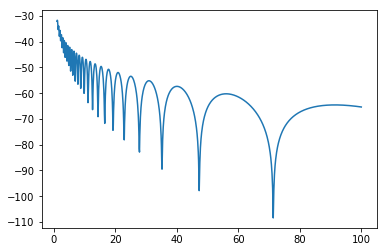

In [196]:
kray = KRayWrapper(SceneBuilder.one_plane(), 860e6)

distance = np.linspace(1, 100, 1000)
pathloss = kray.run(distance)

plt.figure()
plt.plot(distance, pathloss)
plt.show()

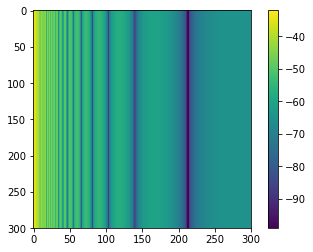

In [194]:
kray = KRayWrapper(SceneBuilder.one_plane(), 860e6)

distance = np.linspace(1, 100, 300)
time     = np.linspace(1, 20, 300)
pathloss = kray.run(distance, time)

plt.figure()
plt.imshow(pathloss)
plt.colorbar()
plt.show()

## Analytical model computation

In [175]:
def to_sin(cos):
    return (1 - cos ** 2) ** .5

#
# Radiation Pattern
#
def __patch_factor(a_cos, t_cos, wavelen, width, length):
    a_sin = to_sin(a_cos)
    t_sin = to_sin(t_cos)
    kw = np.pi / wavelen * width
    kl = np.pi / wavelen * length
    if a_cos < 1e-9:
        return 0
    if np.abs(a_sin) < 1e-9:
        return 1.
    elif np.abs(t_sin) < 1e-9:
        return np.cos(kl * a_sin)
    else:
        return np.sin(kw * a_sin * t_sin) / (kw * a_sin * t_sin) * np.cos(kl * a_sin * t_cos)

def __patch_theta(a_cos, t_cos, wavelen, width, length):
    return __patch_factor(a_cos, t_cos, wavelen, width, length) * t_cos

def __patch_phi(a_cos, t_cos, wavelen, width, length):
    return -1 * __patch_factor(a_cos, t_cos, wavelen, width, length) * to_sin(t_cos) * a_cos

def rp_isotropic(**kwargs):
    return 1.0

def rp_dipole(*, a_cos, **kwargs):
    a_sin = to_sin(a_cos)
    return np.abs(np.cos(np.pi / 2 * a_sin) / a_cos) if a_cos > 1e-9 else 0.

def rp_patch(*, a_cos, t_cos, wavelen, width, length, **kwargs):
    return ( np.abs(__patch_factor(a_cos, t_cos, wavelen, width, length)) *
            (t_cos ** 2 + a_cos ** 2 * to_sin(t_cos) ** 2) ** 0.5)

#
# Reflection
#
def __c_parallel(cosine, permittivity, conductivity, wavelen):
    eta = permittivity - 60j * wavelen * conductivity
    return (eta - cosine ** 2) ** 0.5

def __c_perpendicular(cosine, permittivity, conductivity, wavelen):
    eta = permittivity - 60j * wavelen * conductivity
    return (eta - cosine ** 2) ** 0.5 / eta

def reflection_constant(**kwargs):
    return -1.0 + 0.j

def reflection(*, cosine, polarization, permittivity, conductivity, wavelen, **kwargs):
    sine = (1 - cosine ** 2) ** .5

    if polarization != 0:
        c_parallel = __c_parallel(cosine, permittivity, conductivity, wavelen)
        r_parallel = (sine - c_parallel) / (sine + c_parallel)
    else:
        r_parallel = 0.j

    if polarization != 1:
        c_perpendicular = __c_perpendicular(cosine, permittivity, conductivity, wavelen)
        r_perpendicular = (sine - c_perpendicular) / (sine + c_perpendicular)
    else:
        r_perpendicular = 0.j

    return polarization * r_parallel + (1 - polarization) * r_perpendicular

#
# Pathloss
#
def two_ray_pathloss(*, time, ground_reflection, wavelen,
                     tx_pos, tx_dir_theta, tx_dir_phi, tx_velocity, tx_rp,
                     rx_pos, rx_dir_theta, rx_dir_phi, rx_velocity, rx_rp, **kwargs):

    ground_normal = np.array([0, 0, 1])
    rx_pos_refl = np.array([rx_pos[0], rx_pos[1], -rx_pos[2]])  # Reflect RX relatively the ground

    d0_vector = rx_pos - tx_pos
    d1_vector = rx_pos_refl - tx_pos
    d0 = la.norm(d0_vector)
    d1 = la.norm(d1_vector)
    d0_vector_tx_n = d0_vector / d0
    d0_vector_rx_n = -d0_vector_tx_n
    d1_vector_tx_n = d1_vector / d1
    d1_vector_rx_n = np.array([-d1_vector_tx_n[0], -d1_vector_tx_n[1], d1_vector_tx_n[2]])

    # Radioation pattern
    tx_azimuth_0 = np.dot(d0_vector_tx_n, tx_dir_theta)
    rx_azimuth_0 = np.dot(d0_vector_rx_n, rx_dir_theta)
    tx_azimuth_1 = np.dot(d1_vector_tx_n, tx_dir_theta)
    rx_azimuth_1 = np.dot(d1_vector_rx_n, rx_dir_theta)

    tx_tilt_0 = np.dot(d0_vector_tx_n, tx_dir_phi)
    rx_tilt_0 = np.dot(d0_vector_rx_n, rx_dir_phi)
    tx_tilt_1 = np.dot(d1_vector_tx_n, tx_dir_phi)
    rx_tilt_1 = np.dot(d1_vector_rx_n, rx_dir_phi)

    g0 = (tx_rp(a_cos=tx_azimuth_0, t_cos=tx_tilt_0, wavelen=wavelen, **kwargs) *
          rx_rp(a_cos=rx_azimuth_0, t_cos=rx_tilt_0, wavelen=wavelen, **kwargs))

    g1 = (tx_rp(a_cos=tx_azimuth_1, t_cos=tx_tilt_1, wavelen=wavelen, **kwargs) *
          rx_rp(a_cos=rx_azimuth_1, t_cos=rx_tilt_1, wavelen=wavelen, **kwargs))

    # Reflection
    cos_grazing = -1 * np.dot(d1_vector_rx_n, ground_normal)
    r1 = ground_reflection(cosine=cos_grazing, wavelen=wavelen, **kwargs)

    # Doppler's shift
    relative_velocity = rx_velocity - tx_velocity
    velocity_pr_0 = np.dot(d0_vector_tx_n, relative_velocity)
    velocity_pr_1 = np.dot(d1_vector_tx_n, relative_velocity)
    
    k = 2 * np.pi / wavelen
    return .5/k * (     g0 / d0 * np.exp(-1j * k * (d0 - time * velocity_pr_0)) + 
                   r1 * g1 / d1 * np.exp(-1j * k * (d1 - time * velocity_pr_1)) )


In [222]:
class KRayWrapperTest(KRayWrapperIdentity):
    
    c = 299792458

    def __init__(self, frequency, speed, polarization):
        self.speed = speed
        self.polarization = polarization
        self.frequency = frequency
        self.wavelen = KRayWrapperTest.c / frequency

        
    def model(self, distance, time):
    
        return two_ray_pathloss(
            time=time, ground_reflection=reflection, wavelen=self.wavelen,
            polarization=self.polarization, permittivity=15, conductivity=0.03,
            width=self.wavelen/2, length=self.wavelen/2,

            tx_pos=vec3D(0,0,5), tx_dir_theta=vec3D(np.sin(np.pi/4), 0, -np.cos(np.pi/4)), 
            tx_dir_phi=vec3D(0,1,0), tx_velocity=vec3D(0,0,0), tx_rp=rp_dipole,

            rx_pos=vec3D(distance,0,.5), rx_dir_theta=vec3D(-1,0,0), 
            rx_dir_phi=vec3D(0,-1,0), rx_velocity=vec3D(-self.speed,0,0), rx_rp=rp_dipole)


class KRayWrapperTestSimple(KRayWrapperIdentity):
    
    c = 299792458

    def __init__(self, frequency, tx_height=5., rx_height=5.):
        self.frequency = frequency
        self.wavelen = KRayWrapperTestSimple.c / frequency
        self.k = 2 * np.pi / wavelen

        self.tx_height = tx_height
        self.rx_height = rx_height
        
        self.delta = (tx_height - rx_height) ** 2
        self.sigma = (tx_height + rx_height) ** 2

        
    def model(self, distance, time=0.):

        d0 = (self.delta + distance ** 2) ** 0.5
        d1 = (self.sigma + distance ** 2) ** 0.5
        return 0.5 / self.k * (      np.exp(-1j * self.k * d0) / d0 + 
                               -1. * np.exp(-1j * self.k * d1) / d1  )

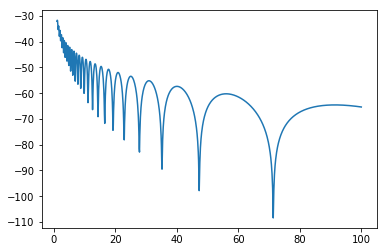

In [225]:
distance = np.linspace(1., 100, 1000)
pathloss = KRayWrapperTestSimple(860e6).run(distance)

plt.figure()
plt.plot(distance, pathloss)
plt.show()

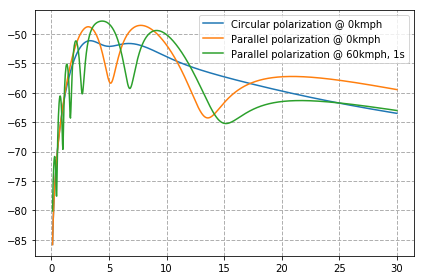

In [210]:
distance = np.linspace(0.1, 30, 1000)

pathloss_c0 = KRayWrapperTest(860e6, 0, .5).run(distance, .0)  
pathloss_p0 = KRayWrapperTest(860e6, 0, 1.).run(distance, .0)
pathloss_p2 = KRayWrapperTest(860e6, 60/3.6, 1.).run(distance, 1.)

plt.figure()

plt.plot(distance, pathloss_c0, label='Circular polarization @ 0kmph')
plt.plot(distance, pathloss_p0, label='Parallel polarization @ 0kmph')
plt.plot(distance, pathloss_p2, label='Parallel polarization @ 60kmph, 1s')

plt.grid(linestyle='--', linewidth=1.0)
plt.legend()
plt.tight_layout()

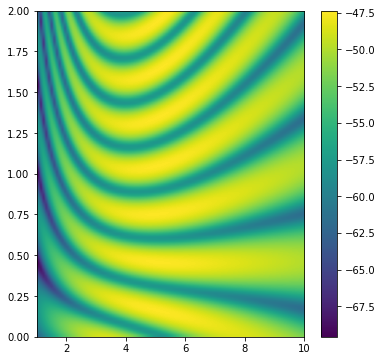

In [204]:
distance = np.linspace(1, 10., 100)
time     = np.linspace(0, 2, 100)
pathloss = KRayWrapperTest(860e6, 60/3.6, 1.).run(distance, time)

plt.figure(figsize=(6,6))
plt.imshow(P, aspect='auto', interpolation='gaussian', origin='lower', extent=[1, 10, 0, 2])
plt.colorbar()